In [4]:
import pandas as pd
import numpy as np
import scipy
import os
import os.path
from matplotlib import cm
from IPython.display import display, HTML

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import calendar

In [5]:
def DTWDistance(s1, s2):
    DTW={}
    w = 2
    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [6]:
df_regLen = pd.read_csv("Data/regLen.csv").drop(["Unnamed: 0", "index"], axis = 1)

groupby_cycles = df_regLen.groupby(["cycle_index","user","cycle_number"]).mean()
user_cycle_df = pd.DataFrame(groupby_cycles.reset_index()[["cycle_index", "user", "cycle_number", "cycle_length"]])
user_cycle_df["cycle_length"] = user_cycle_df["cycle_length"].astype(int)

In [7]:
#missing days interpolated
md = pd.read_csv("Data/missingdays_interpolated.csv")
len(md.cycle_index.unique())

402

In [8]:
cc = pd.read_csv("Data/data_clean2.csv")
len(cc.cycle_index.unique())

172

## Transform cycles for heatmap

In [9]:
def cycle_transform(df, value, save = True):

    value_ = df[["cycle_day", value, "cycle_index"]]

    value_zero = value_.pivot_table(index = "cycle_day", columns="cycle_index", values = value_).fillna(0)
    value_nan = value_.pivot_table(index = "cycle_day", columns="cycle_index", values = value_)

    if save == True:
        value_zero.to_csv("Data/"+value+"_zero.csv")
        value_nan.to_csv("Data/"+value+"_nan.csv")
    return value_zero, value_nan

In [10]:
hr29_norm_zero, hr29_norm_nan = cycle_transform(md[md.cycle_length == 29], "hr_norm", True)
hr29_norm_zero2, hr29_norm_nan2 = cycle_transform(cc[cc.cycle_length == 29], "hr_norm", True)

In [11]:
hr_norm_zero, hr_norm_nan = cycle_transform(md, "hr_norm", True)
hr_norm_zero2, hr_norm_nan2 = cycle_transform(cc, "hr_norm", True)


In [12]:
def plot_heatmap(timeSeries, best_method, best_metric):
    mask = timeSeries.isnull().T
    with sns.axes_style("white"):
        ax = sns.clustermap(timeSeries.T.fillna(0), metric=best_metric,method=best_method, col_cluster = False,figsize=(17,15),mask = mask)
        plt.show()

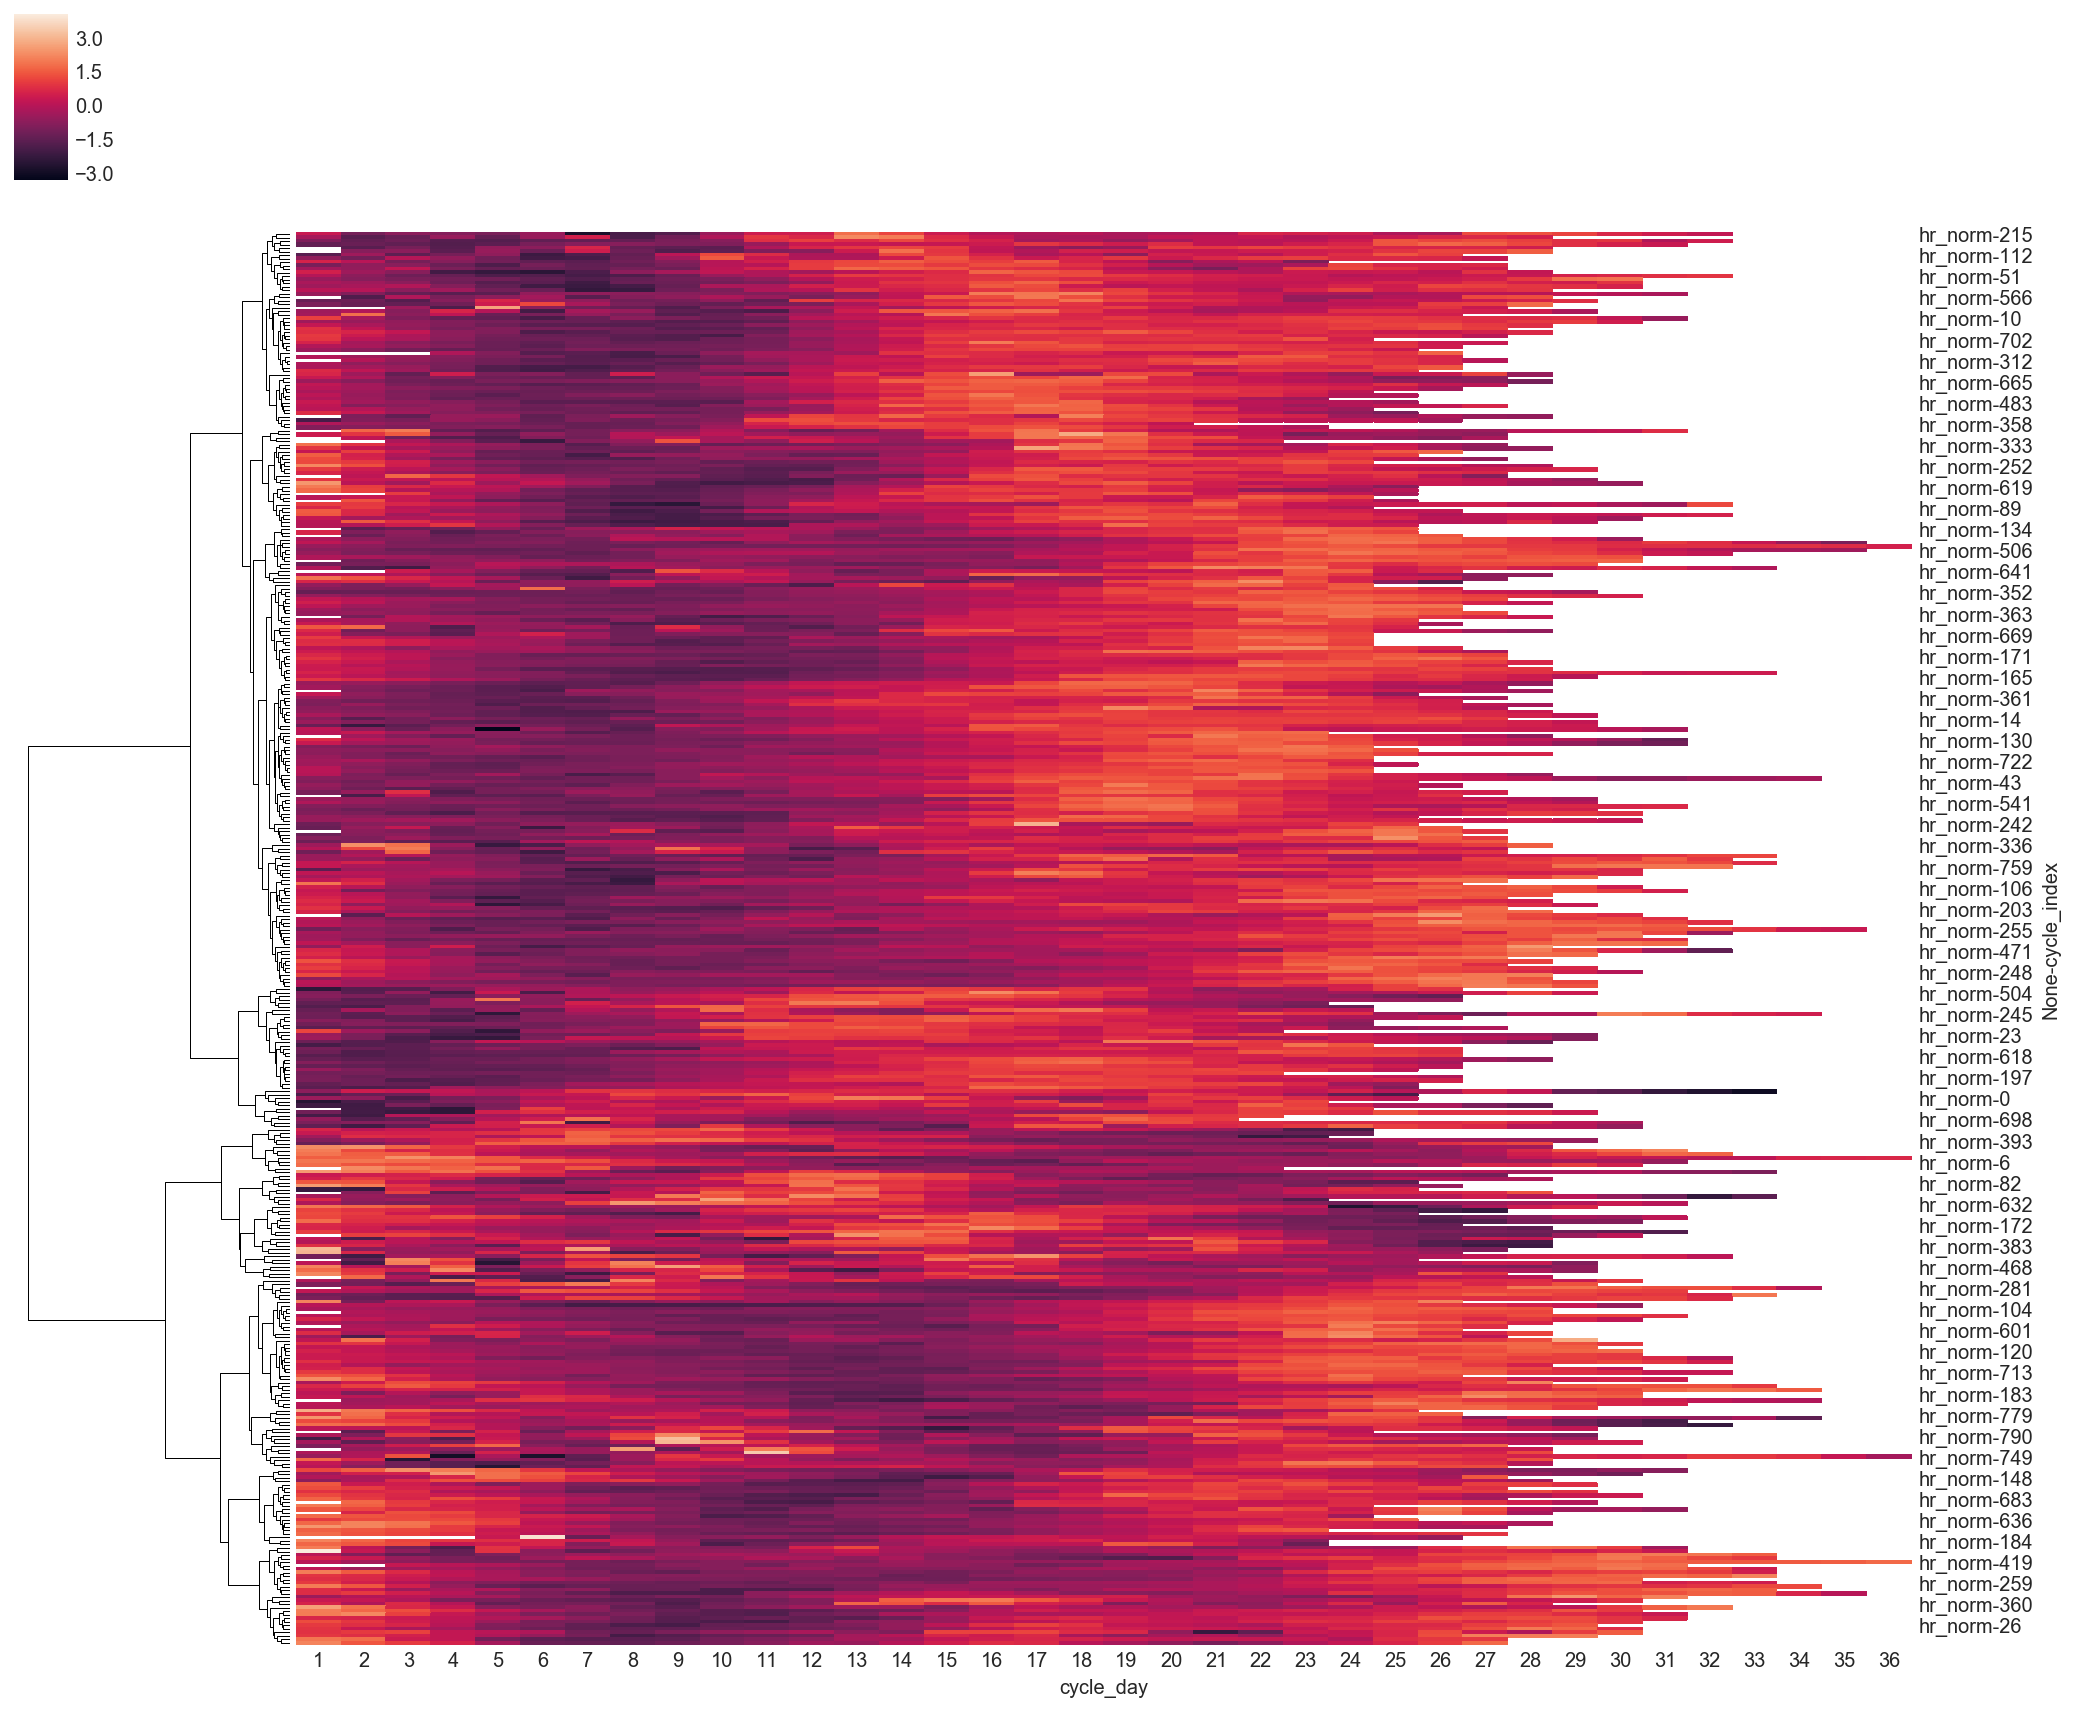

In [13]:
timeSeries = hr_norm_nan
plot_heatmap(timeSeries, "complete", "braycurtis")

### advanced heatmap with annotation

In [18]:
def print_heatmap2(timeSeries, user_cycle_df, cycle_length, metric, method, first_cycle = True):
    import seaborn as sns; sns.set(color_codes=True)
    
    if cycle_length == "all":
        users = user_cycle_df[["user","cycle_index","cycle_number"]]
        users = users.set_index(users.cycle_index)
        figsize = (15,30)
        
    else:
        users = user_cycle_df[user_cycle_df.cycle_length == cycle_length][["user","cycle_index","cycle_number"]]
        users = users.set_index(users.cycle_index)
        figsize = (15,15)
        
    timeSeries = timeSeries.T.reset_index().set_index("cycle_index").drop("level_0", axis = 1)
    
    print(users)
    
    max_cycle_numbers = len(users.cycle_number.unique())-3
    colors = "rrr"+("w"*max_cycle_numbers)
    print("users;", users.user)
    lut = dict(zip(users.user.unique(), sns.hls_palette(len(set(users.user)),l=0.4)))
    print("lut:", lut)
    row_colors = users.user.map(lut).rename("user")
    print("row_colors:",row_colors)
    
    lut2 = dict(zip(users.cycle_number.unique(), colors))
    row_colors2 = users.cycle_number.map(lut2).rename("first cycle")

    row_color = [row_colors2, row_colors]
    if first_cycle == False:
        row_color = row_colors

    mask = timeSeries.isnull()
    with sns.axes_style("white"):
        ax = sns.clustermap(timeSeries.fillna(0), 
                    metric=metric,method=method, 
                    col_cluster = False,
                    figsize=figsize, 
                    row_colors = row_color,
                    mask = mask)

              user  cycle_index  cycle_number
cycle_index                                  
22             406           22             6
23             406           23             7
24             406           24             8
26             406           26            10
27             406           27            11
30             406           30            14
48             411           48             1
52             411           52             5
54             411           54             7
57             411           57            10
81             423           81             7
83             423           83             9
84             423           84            10
90             427           90             4
93             427           93             7
99             431           99             1
126            466          126             1
147            473          147             2
154            473          154             9
175            487          175   

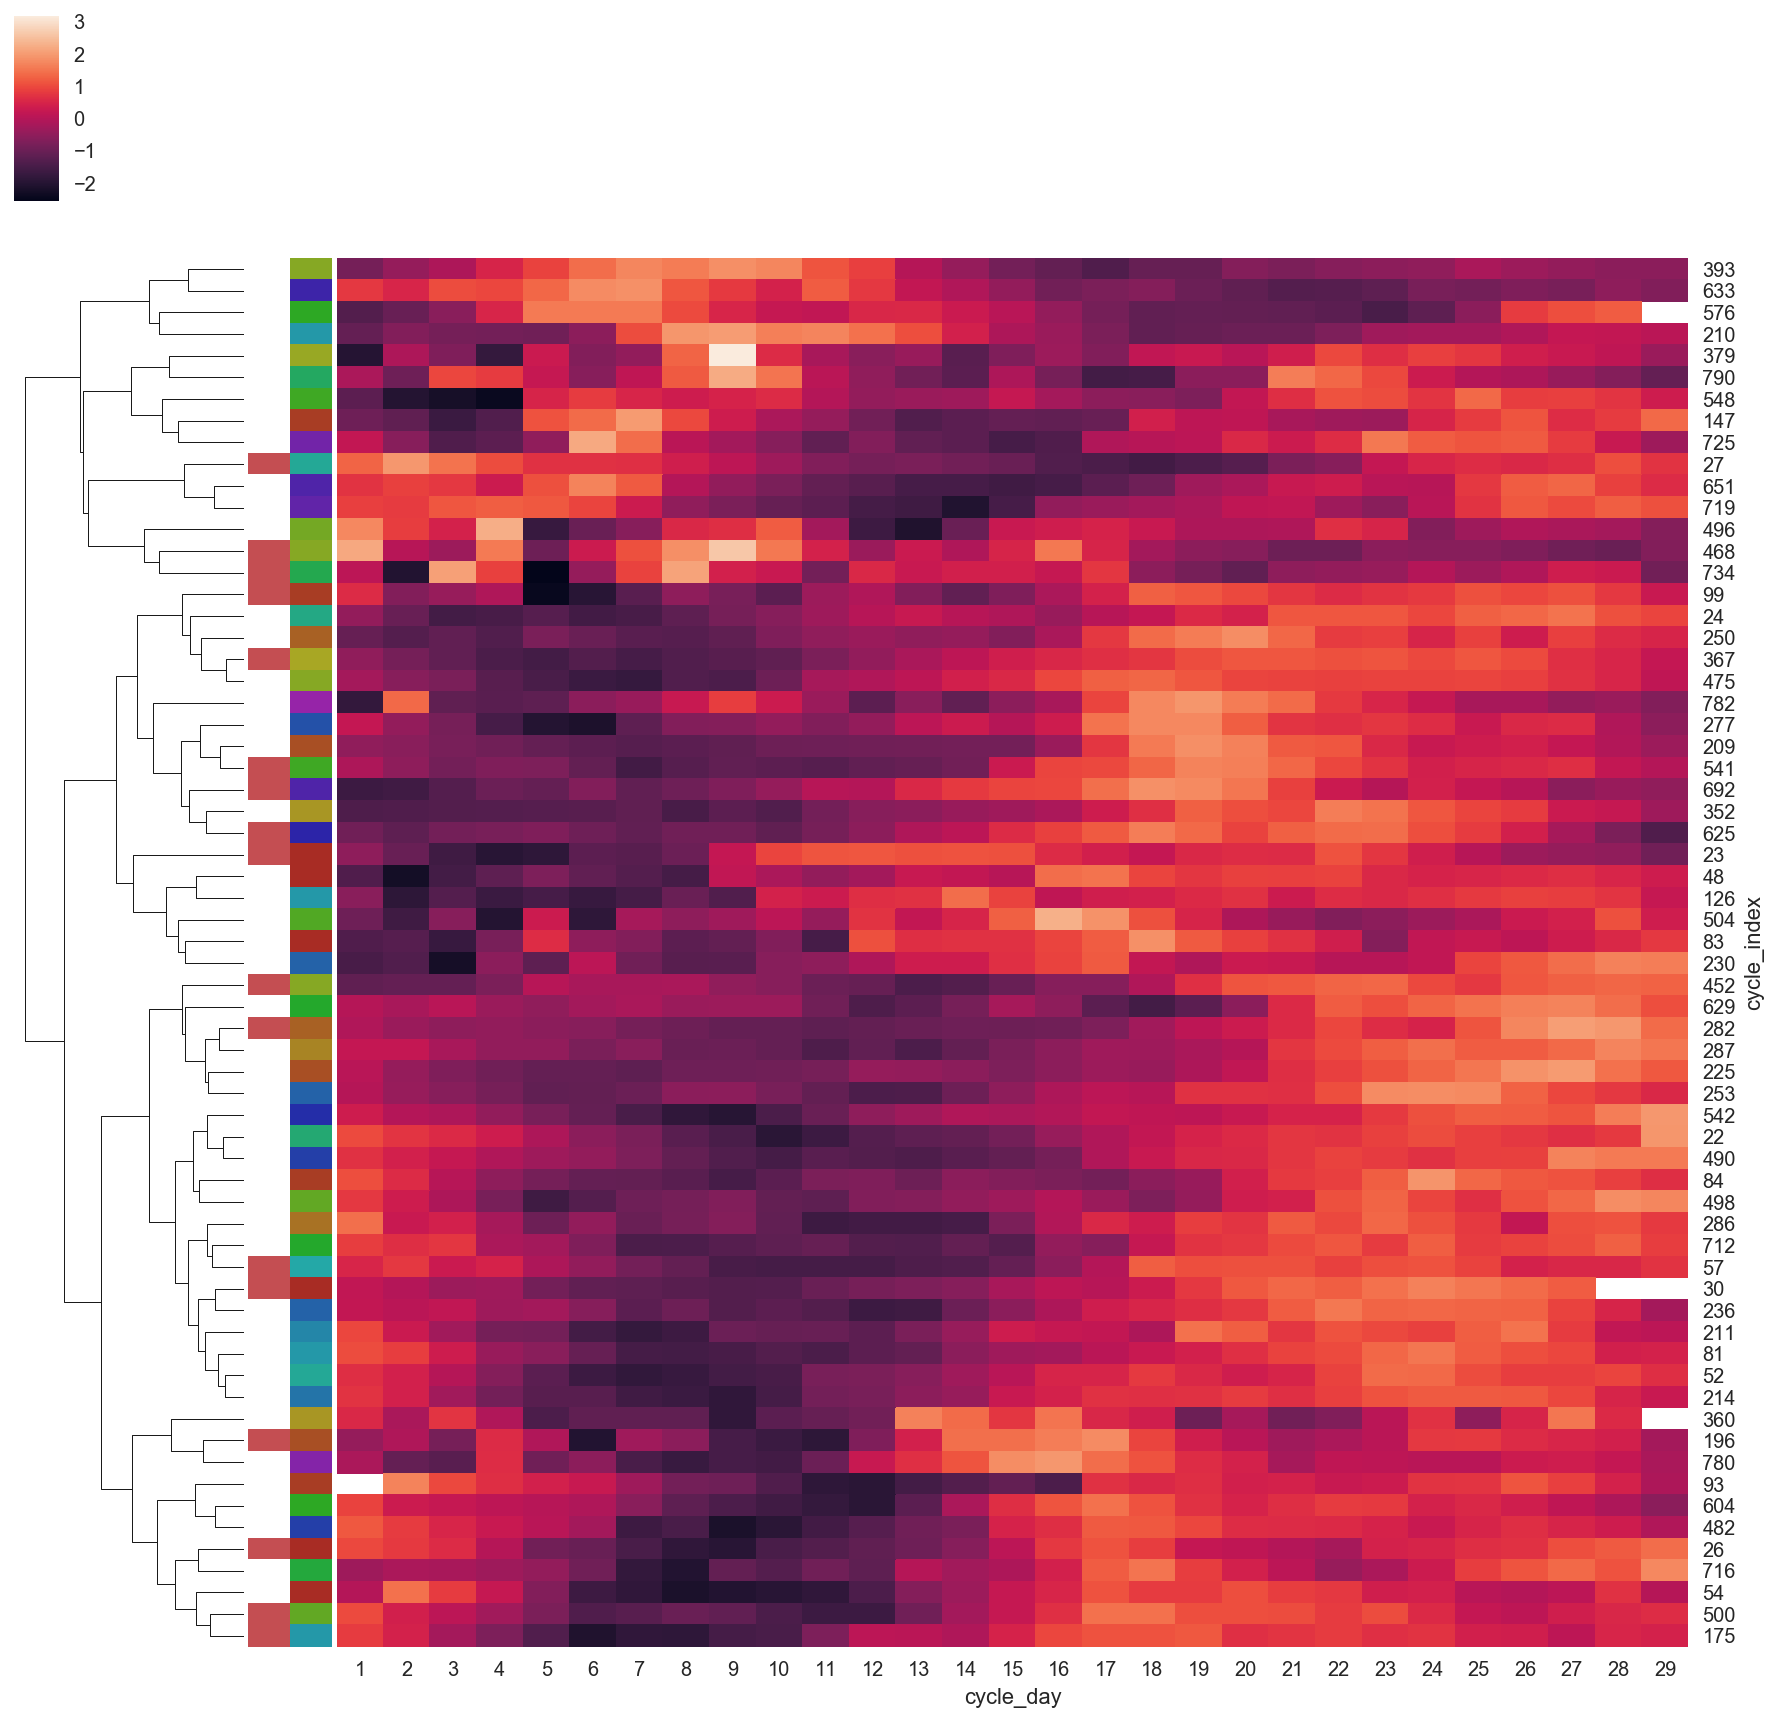

In [19]:
timeSeries = pd.concat([hr29_norm_nan, hr29_norm_nan2], axis=1, join_axes=[hr29_norm_nan.index])


print_heatmap2(timeSeries, user_cycle_df, 29, DTWDistance, "complete")

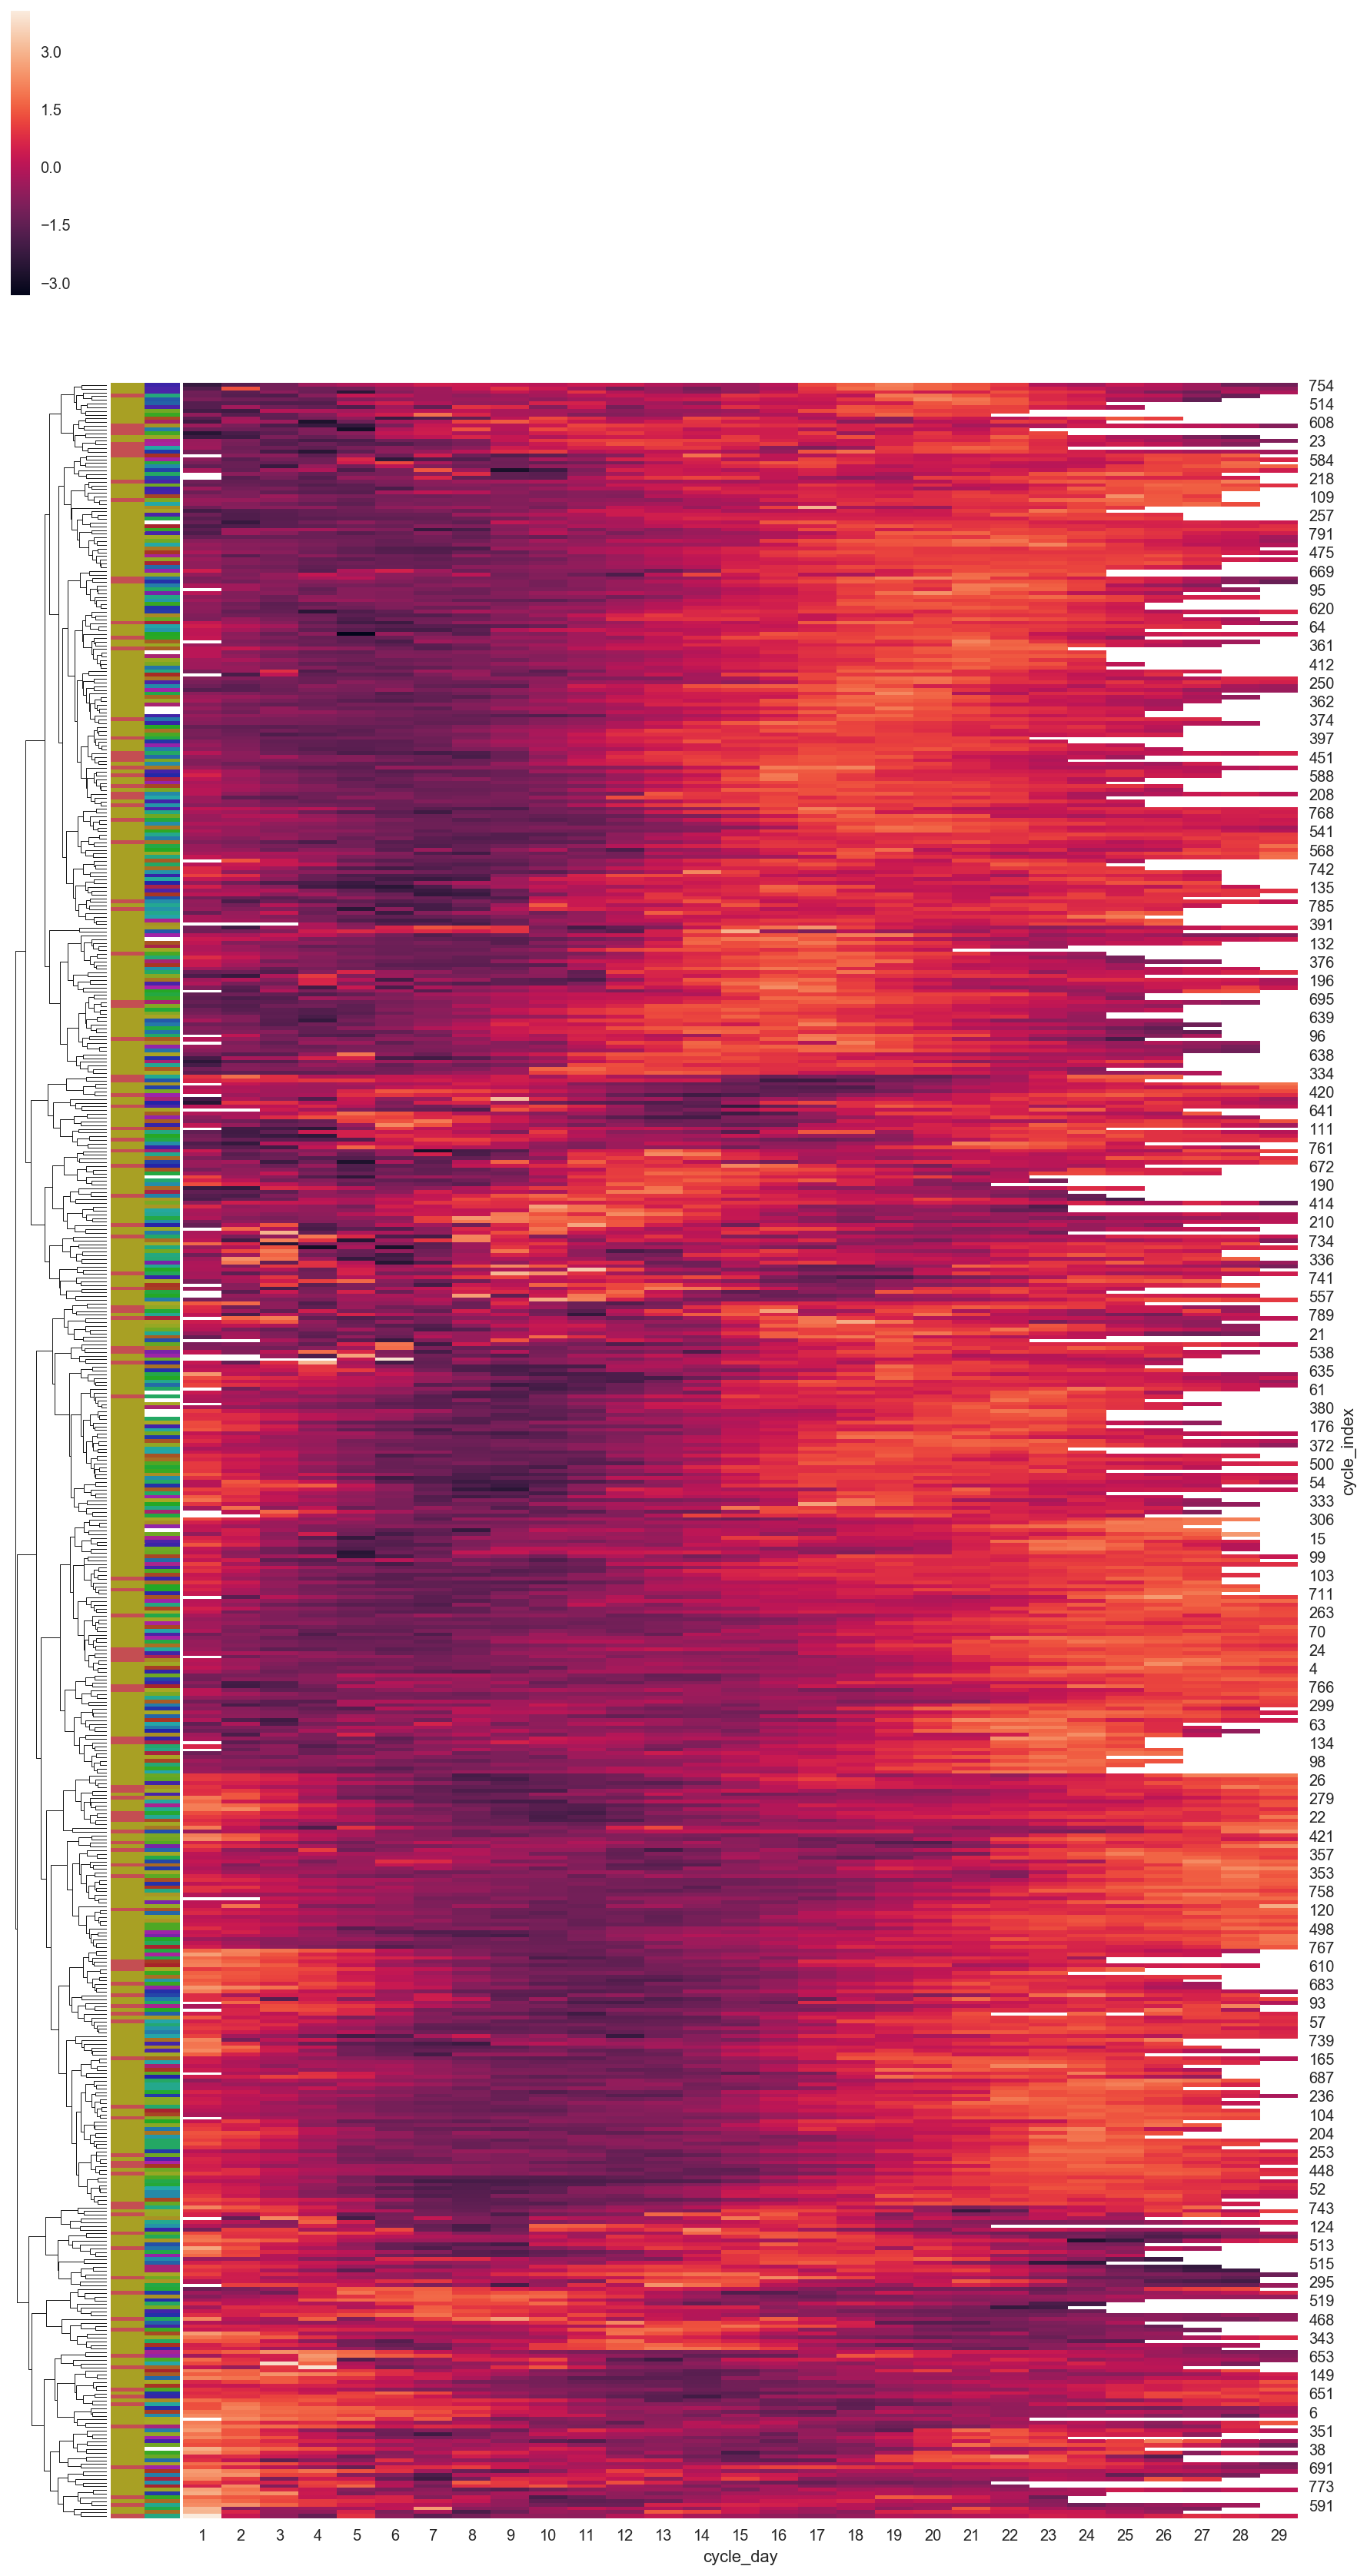

In [206]:
timeSeries = pd.concat([hr_norm_nan, hr_norm_nan2], axis=1, join_axes=[hr29_norm_nan.index])
print_heatmap2(timeSeries, user_cycle_df, "all", DTWDistance, "complete")

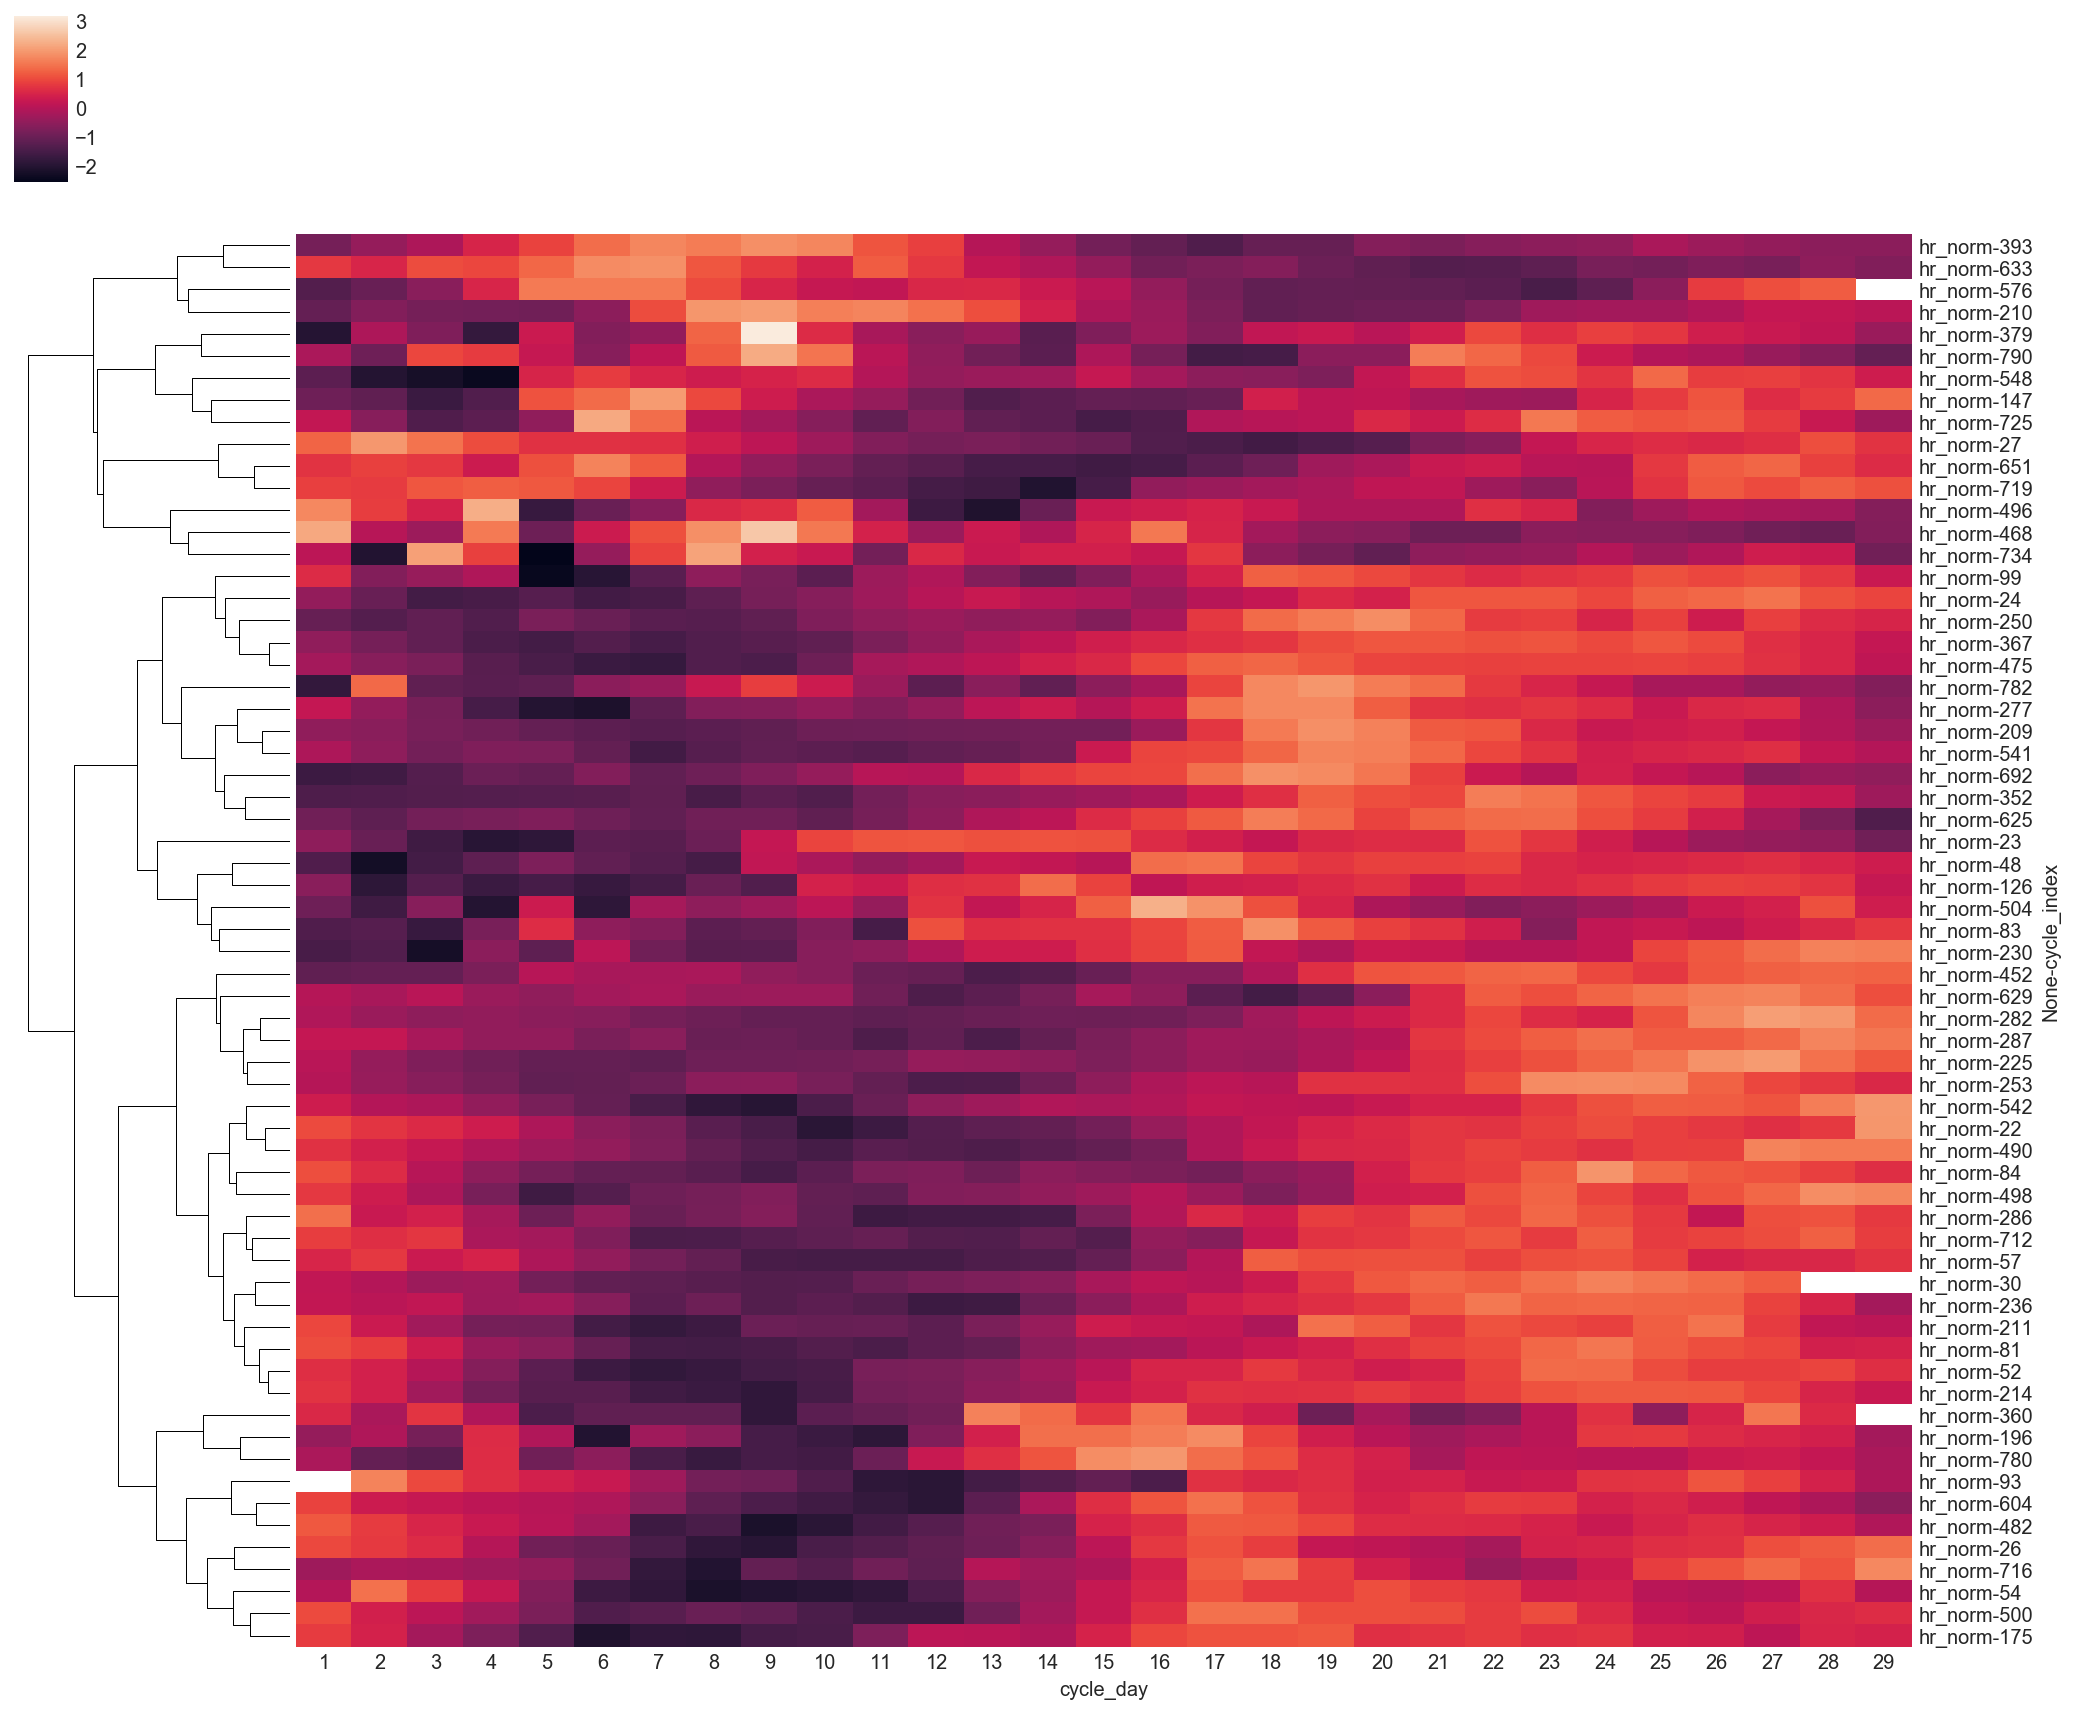

In [16]:
timeSeries = pd.concat([hr29_norm_nan, hr29_norm_nan2], axis=1, join_axes=[hr29_norm_nan.index])
plot_heatmap(timeSeries, "complete", DTWDistance)

In [17]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):

        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])

        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2

    return np.sqrt(LB_sum)

In [244]:
from dtaidistance import dtw
def dtw_metric(x, y):
    distance = dtw.distance(x,y)
    return distance # correlation to distance: range 0 to 2

In [245]:
timeSeries = pd.concat([hr29_norm_zero, hr29_norm_zero2], axis=1, join_axes=[hr29_norm_zero.index])

s1 = timeSeries.hr_norm[93.0].values
s2 = timeSeries.hr_norm[23.0].values

In [246]:
dtw_metric(s1,s2)

3.6011212582492598